In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from compass import *
# from math import comb
import operator as op
from functools import reduce

def comb(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom 

In [3]:
def error_count(m,mx,my,mz):
    return comb(m,mx)*comb(m-mx,my)*comb(m-mx-my,mz)

def error_prob(m,mx,my,mz,px,py,pz):
    return error_count(m,mx,my,mz) * error_rate(m,mx,my,mz,px,py,pz)

def error_rate(m,mx,my,mz,px,py,pz):
    return px**mx * py**my * pz**mz * (1-px-py-pz)**(m-mx-my-mz)

def count_per_weight(L,wt):
    return 3**wt*comb(L,L-wt)

# Analytical Pauli error distribution

## Combinatorics check

In [9]:
m = 6
mx = my = 1
mz = 2
all_errors = np.array(list(itertools.product([0,1,2,3],repeat=m)))
ms = np.array([(all_errors==i).sum(1) for i in range(1,4)]).T
num_error = (ms==[mx,my,mz]).all(1).sum()
num_error - error_count(m,mx,my,mz)

0

In [61]:
%%timeit
ms = np.array([(all_errors==i).sum(1) for i in range(1,4)]).T
num_error = (ms==[mx,my,mz]).all(1).sum()

309 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
%timeit error_count(m,mx,my,mz)

373 ns ± 7.33 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Probability check

In [91]:
L = 6
px,py,pz = [0.1,0.3,0.2]
N = int(1e6)
errors = np.random.choice(4,size=[N,L],p=[1-px-py-pz,px,py,pz])
ms = np.array([(errors==i).sum(1) for i in range(1,4)]).T

In [93]:
# check probability of [mx,my,mz]
mx,my,mz = [2,2,1]
print(error_prob(L,mx,my,mz,px,py,pz))
print((ms==[mx,my,mz]).all(1).sum()/N)

0.012960000000000005
0.012816


In [99]:
# check probability of an error string
rand_err = np.random.randint(4,size=L)
xyz_weight = [(rand_err==i).sum() for i in range(1,4)]
print((errors == rand_err).all(1).sum()/N)
print(error_rate(L,*xyz_weight,px,py,pz))

0.000458
0.0004320000000000001


In [100]:
e = []
for n in range(N):
    e.append([])
    for q in range(m):
        s = np.random.uniform(0,1)
        if 0<=s<px:
            e[-1].append(1)
        elif px<=s<px+py:
            e[-1].append(2)
        elif px+py<=s<px+py+pz:
            e[-1].append(3)
        else:
            e[-1].append(0)
e = np.array(e)

In [115]:
rand_err = np.random.randint(4,size=L)
xyz_weight = [(rand_err==i).sum() for i in range(1,4)]
print((e == rand_err).all(1).sum()/N)
print(error_rate(L,*xyz_weight,px,py,pz))

0.001157
0.0011520000000000007


## Error histogram and lat.test() check

In [119]:
L = 9
px,py,pz = [0.1,0.3,0.2]

all_errors = np.array(list(itertools.product([0,1,2,3],repeat=L)))
all_errors_string = [''.join(error) for error in itertools.product('IXYZ',repeat=L)]
xyz_weights = np.array([(all_errors==i).sum(1) for i in range(1,4)]).T

prob = np.zeros(len(all_errors))
for xyz_weight in np.unique(xyz_weights,axis=0):
    errors = all_errors[(xyz_weights == xyz_weight).all(1)]
    prob[(xyz_weights == xyz_weight).all(1)] = error_rate(L,*xyz_weight,px,py,pz)
all_error_hist = dict(zip(all_errors_string,prob))

In [124]:
N = int(1e6)
weight = 2
# numerical
hist, amp_below, amp_above = check_distribution_globalbias(L, 0, weight, px, py, pz, N)
# analytical
ind = np.where(xyz_weights.sum(1)<=weight)
band_error_hist = dict(zip(np.array(all_errors_string)[ind],prob[ind]))

print(len(hist))
print(len(band_error_hist))

352
352


In [128]:
for error in hist.keys():
    print(hist[error],band_error_hist[error])

0.00015699999999999967 0.0001474560000000002
0.0001069999999999998 9.830400000000013e-05
9.999999999999982e-05 9.830400000000013e-05
3.999999999999998e-05 4.915200000000007e-05
6.79999999999999e-05 6.55360000000001e-05
0.0001859999999999996 0.0001966080000000003
9.899999999999982e-05 9.830400000000013e-05
0.00013899999999999972 0.0001474560000000002
8.699999999999985e-05 9.830400000000013e-05
0.0001789999999999996 0.0001966080000000003
0.00016199999999999966 0.0001474560000000002
3.4e-05 3.276800000000005e-05
4.099999999999998e-05 3.276800000000005e-05
0.0001069999999999998 9.830400000000013e-05
0.0001489999999999997 0.0001474560000000002
9.599999999999983e-05 9.830400000000013e-05
5.2999999999999947e-05 6.55360000000001e-05
0.00011399999999999978 9.830400000000013e-05
0.0001029999999999998 9.830400000000013e-05
0.00010199999999999981 9.830400000000013e-05
9.099999999999984e-05 9.830400000000013e-05
0.0001459999999999997 0.0001474560000000002
2.5000000000000008e-05 3.276800000000005e-0

In [137]:
from compass import *

lat = Lattice_2d(3,3)
lat.color_lattice('RBBR')
print(lat)

000---001---002
 |  #  |  #  |
003---004---005
 |  #  |  #  |
006---007---008



In [138]:
lat.test(band_error_hist)

0.012091392000000024

In [139]:
lat.test(hist)

0.012040999999999986

# Logical error rate

## 3x3 lattice

In [27]:
L = 9
px,py,pz = [0.1,0.3,0.2]

all_errors = np.array(list(itertools.product([0,1,2,3],repeat=L)))
all_errors_string = [''.join(error) for error in itertools.product('IXYZ',repeat=L)]
xyz_weights = np.array([(all_errors==i).sum(1) for i in range(1,4)]).T

prob = np.zeros(len(all_errors))
for xyz_weight in np.unique(xyz_weights,axis=0):
    errors = all_errors[(xyz_weights == xyz_weight).all(1)]
    prob[(xyz_weights == xyz_weight).all(1)] = error_rate(L,*xyz_weight,px,py,pz)
all_error_hist = dict(zip(all_errors_string,prob))

In [28]:
banded_prob = []
banded_hist = []
for weight in range(L+1):
    ind = np.where(xyz_weights.sum(1)==weight)
    banded_prob.append(prob[ind].sum())
    banded_hist.append(dict(zip(np.array(all_errors_string)[ind],prob[ind])))
banded_prob = np.array(banded_prob)
banded_count = np.array([len(hist) for hist in banded_hist])/len(all_error_hist)

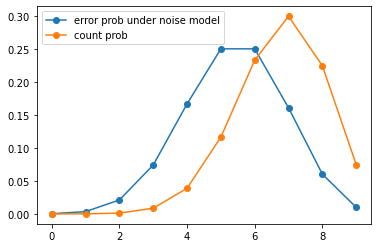

In [195]:
plt.plot(banded_prob,'o-',label='error prob under noise model')
plt.plot(banded_count,'o-',label='count prob')
plt.legend()
plt.show()

In [176]:
lat = Lattice_2d(3,3)
lat.color_lattice('RBBR')
print(lat)

000---001---002
 |  #  |  #  |
003---004---005
 |  #  |  #  |
006---007---008



In [232]:
banded_psuccess = banded_prob - banded_pfail

In [201]:
banded_psuccess = []
for i,hist in enumerate(banded_hist):
    banded_psuccess.append(banded_prob[i]-lat.test(hist))
    print(f'Success rate at weight {i}: {banded_psuccess[i]:.5f} / {banded_prob[i]:.5f} = {banded_psuccess[i]/banded_prob[i]*100:.0f}%')
banded_psuccess = np.array(banded_psuccess)

Success rate at weight 0: 0.00026 / 0.00026 = 100%
Success rate at weight 1: 0.00354 / 0.00354 = 100%
Success rate at weight 2: 0.00914 / 0.02123 = 43%
Success rate at weight 3: 0.01772 / 0.07432 = 24%
Success rate at weight 4: 0.03757 / 0.16722 = 22%
Success rate at weight 5: 0.06103 / 0.25082 = 24%
Success rate at weight 6: 0.06501 / 0.25082 = 26%
Success rate at weight 7: 0.04500 / 0.16124 = 28%
Success rate at weight 8: 0.01342 / 0.06047 = 22%
Success rate at weight 9: 0.00107 / 0.01008 = 11%


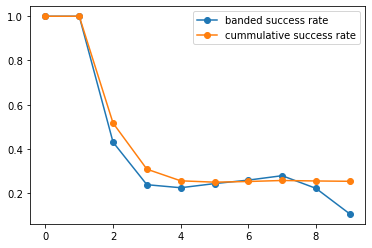

In [231]:
avg_psuccess = np.array([banded_psuccess[:i+1].sum() for i in range(L+1)])
avg_prob = np.array([banded_prob[:i+1].sum() for i in range(L+1)])

plt.plot(banded_psuccess/banded_prob,'o-',label='banded success rate')
plt.plot(avg_psuccess/avg_prob,'o-',label='average success rate')
plt.legend()
plt.show()

In [233]:
banded_psuccess

array([0.00026214, 0.00353894, 0.00914227, 0.0177193 , 0.03756954,
       0.06102528, 0.06501325, 0.04500403, 0.01341626, 0.00107136])

## 4x4 lattice

### Generate Pauli error strings below a weight

In [5]:
def pauli_error(errs,pos,wt,L):
    if len(pos) == 0:
        for i in range(L):
            pauli_error(errs,pos+[i],wt,L)
    elif len(pos)<wt:
        for i in range(pos[-1]+1,L):
            pauli_error(errs,pos+[i],wt,L)
    else:
        for pauli_string in itertools.product([1,2,3],repeat=wt):
            err = np.zeros(L,dtype=int)
            err[pos] = np.array(pauli_string)
            errs.append(err)
    
def num2string(paulis):
    d = {0:'I',1:'X',2:'Y',3:'Z'}
    strings = []
    for pauli in paulis:
        strings.append(''.join(np.vectorize(d.get)(pauli)))
    return strings

In [4]:
# verify with all_errors
L = 9
wt_max = 9
px,py,pz = [0.1,0.3,0.2]

# general way
errors_below = [np.zeros(L,dtype=int)]
for wt in range(wt_max):
    pauli_error(errors_below,[],wt+1,L)
errors_below = np.array(errors_below)
errors_below_string = num2string(errors_below)
xyz_weights = np.array([(errors_below==i).sum(1) for i in range(1,4)]).T

prob = np.zeros(len(errors_below))
for xyz_weight in np.unique(xyz_weights,axis=0):
    errors = errors_below[(xyz_weights == xyz_weight).all(1)]
    prob[(xyz_weights == xyz_weight).all(1)] = error_rate(L,*xyz_weight,px,py,pz)
errors_below_hist = dict(zip(errors_below_string,prob))

In [5]:
# old way using itertools
all_errors = np.array(list(itertools.product([0,1,2,3],repeat=L)))
all_errors_string = [''.join(error) for error in itertools.product('IXYZ',repeat=L)]
xyz_weights = np.array([(all_errors==i).sum(1) for i in range(1,4)]).T

prob = np.zeros(len(all_errors))
for xyz_weight in np.unique(xyz_weights,axis=0):
    errors = all_errors[(xyz_weights == xyz_weight).all(1)]
    prob[(xyz_weights == xyz_weight).all(1)] = error_rate(L,*xyz_weight,px,py,pz)
all_error_hist = dict(zip(all_errors_string,prob))

In [6]:
errors_below_hist==all_error_hist

True

In [15]:
errors_below_hist.keys()==all_error_hist.keys()

True

### Now 4x4

In [47]:
nrow, ncol = 4,4
px,py,pz = [0.1,0.3,0.2]
wt_max = 5
L = nrow*ncol

banded_hist = []
banded_prob = []
# general way
for wt in range(wt_max):
    errors_below = []
    pauli_error(errors_below,[],wt+1,L)
    errors_below = np.array(errors_below)
    errors_below_string = num2string(errors_below)
    xyz_weights = np.array([(errors_below==i).sum(1) for i in range(1,4)]).T

    prob = np.zeros(len(errors_below))
    for xyz_weight in np.unique(xyz_weights,axis=0):
        errors = errors_below[(xyz_weights == xyz_weight).all(1)]
        prob[(xyz_weights == xyz_weight).all(1)] = error_rate(L,*xyz_weight,px,py,pz)
    errors_below_hist = dict(zip(errors_below_string,prob))
    
    banded_hist.append(errors_below_hist)
    banded_prob.append(prob.sum())
    print(len(errors_below_hist))
banded_prob = np.array(banded_prob)
banded_count = np.array([len(hist) for hist in banded_hist])/4**L

48
1080
15120
147420
1061424


In [73]:
for wt in range(wt_max):
    print(count_per_weight(L,wt+1))

48
1080
15120
147420
1061424


In [53]:
banded_prob.sum()

0.019141488122265647

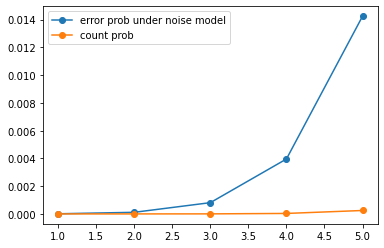

In [65]:
plt.plot(range(1,wt_max+1),banded_prob,'o-',label='error prob under noise model')
plt.plot(range(1,wt_max+1),banded_count,'o-',label='count prob')
plt.legend()
plt.show()

In [57]:
lat = Lattice_2d(nrow,ncol)
lat.color_lattice('RBRBRBRBR')
print(lat)

000---001---002---003
 |  #  |  #  |  #  |
004---005---006---007
 |  #  |  #  |  #  |
008---009---010---011
 |  #  |  #  |  #  |
012---013---014---015



In [62]:
banded_psuccess = []
for i,hist in enumerate(banded_hist):
    banded_psuccess.append(banded_prob[i]-lat.test(hist))
    print(f'Success rate at weight {i+1}: {banded_psuccess[i]:.5f} / {banded_prob[i]:.5f} = {banded_psuccess[i]/banded_prob[i]*100:.0f}%')
banded_psuccess = np.array(banded_psuccess)

Success rate at weight 1: 0.00001 / 0.00001 = 100%
Success rate at weight 2: 0.00009 / 0.00012 = 75%
Success rate at weight 3: 0.00040 / 0.00081 = 50%
Success rate at weight 4: 0.00137 / 0.00396 = 35%
Success rate at weight 5: 0.00396 / 0.01425 = 28%


In [66]:
banded_psuccess

array([1.03079215e-05, 8.73488974e-05, 4.04874487e-04, 1.37145520e-03,
       3.96298100e-03])

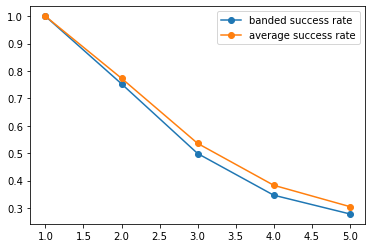

In [80]:
avg_psuccess = np.array([banded_psuccess[:i+1].sum() for i in range(wt_max)])
avg_prob = np.array([banded_prob[:i+1].sum() for i in range(wt_max)])

plt.plot(range(1,wt_max+1),banded_psuccess/banded_prob,'o-',label='banded success rate')
plt.plot(range(1,wt_max+1),avg_psuccess/avg_prob,'o-',label='average success rate')
plt.legend()
plt.show()

## 5x5 lattice

In [6]:
nrow, ncol = 5,5
px,py,pz = [0.1,0.3,0.2]
wt_max = 5
L = nrow*ncol

for wt in range(wt_max):
    print(count_per_weight(L,wt+1))

banded_hist = []
banded_prob = []
# general way
for wt in range(wt_max):
    errors_below = []
    pauli_error(errors_below,[],wt+1,L)
    errors_below = np.array(errors_below)
    errors_below_string = num2string(errors_below)
    xyz_weights = np.array([(errors_below==i).sum(1) for i in range(1,4)]).T

    prob = np.zeros(len(errors_below))
    for xyz_weight in np.unique(xyz_weights,axis=0):
        errors = errors_below[(xyz_weights == xyz_weight).all(1)]
        prob[(xyz_weights == xyz_weight).all(1)] = error_rate(L,*xyz_weight,px,py,pz)
    errors_below_hist = dict(zip(errors_below_string,prob))
    
    banded_hist.append(errors_below_hist)
    banded_prob.append(prob.sum())
    print(len(errors_below_hist))
banded_prob = np.array(banded_prob)
banded_count = np.array([len(hist) for hist in banded_hist])/4**L

75
2700
62100
1024650
12910590
75
2700
62100
1024650
12910590


In [7]:
banded_prob.sum()

5.3589633787849084e-05

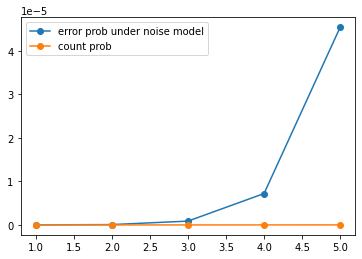

In [8]:
plt.plot(range(1,wt_max+1),banded_prob,'o-',label='error prob under noise model')
plt.plot(range(1,wt_max+1),banded_count,'o-',label='count prob')
plt.legend()
plt.show()

In [5]:
from compass import *
nrow=ncol=5

In [ ]:
lat = Lattice_2d(nrow,ncol)
lat.color_lattice('RBRBBRBRRBRBBRBR')
print(lat)

In [ ]:
banded_psuccess = []
for i,hist in enumerate(banded_hist):
    banded_psuccess.append(banded_prob[i]-lat.test(hist))
    print(f'Success rate at weight {i+1}: {banded_psuccess[i]:.5f} / {banded_prob[i]:.5f} = {banded_psuccess[i]/banded_prob[i]*100:.0f}%')
banded_psuccess = np.array(banded_psuccess)

In [ ]:
banded_psuccess

In [ ]:
avg_psuccess = np.array([banded_psuccess[:i+1].sum() for i in range(wt_max)])
avg_prob = np.array([banded_prob[:i+1].sum() for i in range(wt_max)])

plt.plot(range(1,wt_max+1),banded_psuccess/banded_prob,'o-',label='banded success rate')
plt.plot(range(1,wt_max+1),avg_psuccess/avg_prob,'o-',label='average success rate')
plt.legend()
plt.show()